# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.expand_frame_repr', False)

%matplotlib inline

df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
print(df.shape)
df.head()

(45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>
`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
#how many users are in the dataset and how many articles are
print(f'There are {df.article_id.nunique()} unique articles in df')
print(f'There are {df.email.nunique()} unique emails in df')

There are 714 unique articles in df
There are 5148 unique emails in df


In [4]:
# how many articles a user interacts with
print('User-article interactions mean: {:.2f}'.format(df.groupby('email')['article_id'].count().mean()))

User-article interactions mean: 8.93


In [5]:
#most interactions
print(df.groupby('article_id')['email'].count().reset_index().sort_values('email', ascending = False).head(10))

     article_id  email
699      1429.0    937
625      1330.0    927
701      1431.0    671
697      1427.0    643
652      1364.0    627
614      1314.0    614
600      1293.0    572
526      1170.0    565
518      1162.0    512
608      1304.0    483


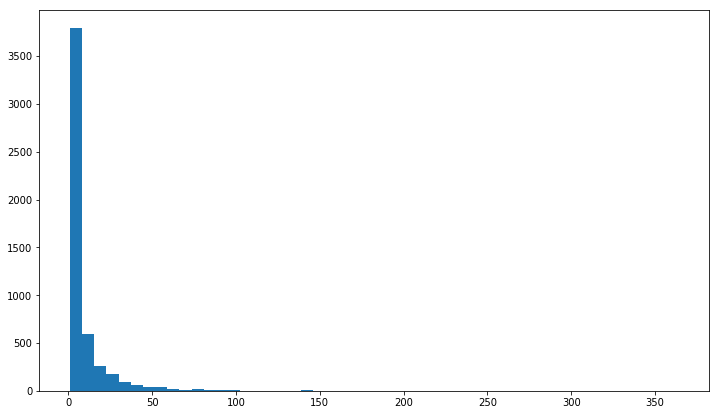

In [6]:
dist = df.groupby('email')['article_id'].count()
fig, axs = plt.subplots(figsize = (12,7))
axs = plt.hist(dist, bins = 50)
plt.show()

In [7]:
df.groupby('email')['article_id'].count().sort_values(ascending = False).head(1)[0]

364

In [8]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3
max_views_by_user = 364

In [9]:
print(median_val)
print(max_views_by_user)

3
364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
df_content.shape

(1056, 5)

In [11]:
# Find and explore duplicate articles
df_content['article_id'].value_counts().head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset = 'article_id', keep = 'first')
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
df.shape[0]

45993

In [14]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051# The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
list(df.groupby(['article_id', 'title'])['user_id'].count() \
        .reset_index().sort_values('user_id', ascending = False).head(5)['article_id'].values[0:5])

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles = list(df.groupby(['article_id', 'title'])['user_id'].count() \
        .reset_index().sort_values('user_id', ascending = False).head(n).title.values[0:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles = list(df.groupby(['article_id', 'title'])['user_id'].count() \
        .reset_index().sort_values('user_id', ascending = False).head(n)['article_id'].values[0:n])
    top_articles = [str(i) for i in top_articles]
 
    return top_articles # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>
* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
a = df.groupby(['user_id', 'article_id'])['user_id'].max().unstack()
a = a.notnull().astype('int')

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item = df.groupby(['user_id', 'article_id'])['user_id'].max().unstack()
    user_item = user_item.notnull().astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` The function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [23]:
sim = dict()
for user in range(1,9):
    dot = np.dot(user_item.loc[1], user_item.loc[user])
    sim[user] = dot

sort = sorted(sim.items(), key = lambda x:x[1], reverse = True)
ids = [dicts[0] for dicts in sort]
ids = [i for i in ids if i != 1]

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    sim = dict()
    for user in range(1,user_item.shape[0]):
        dot = np.dot(user_item.loc[user_id], user_item.loc[user])
        sim[user] = dot
    
    # sort by similarity
    sort = sorted(sim.items(), key = lambda x:x[1], reverse = True)
    # create list of just the ids
    ids = [dicts[0] for dicts in sort]
    # remove the own user's id
    most_similar_users = [idx for idx in ids if idx != user_id]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [26]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


`3.` Use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [27]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    #all_articles = df.groupby(['article_id'])['article_id', 'title'].last().reset_index(drop = True)
    article_names = list(df.query('article_id == @article_ids')['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user = user_item.loc[user_id]
    idx = list(np.where(user == 1)[0])
    user = pd.Series(user).reset_index()
    article_ids = list(user.loc[idx]['article_id'].unique())
    article_ids = [str(i) for i in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #Your code here
    similar = find_similar_users(user_id)
    user_article_lists = []
    for i in similar:
        ids, nms = get_user_articles(i)
        user_article_lists.append(ids)

    all_articles = [val for lists in user_article_lists for val in lists]
    idxs, nms = get_user_articles(user_id)
    all_articles = list(all_articles)
    all_recs = [article for article in all_articles if article not in idxs]
    recs = all_recs[:m]
    
    
    return recs # return your recommendations for this user_id    

In [28]:
# Check Results
get_article_names(user_user_recs(1 ,10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
df.groupby('user_id').count()

,article_id,title
user_id,,
1,47,47
2,6,6
3,82,82
4,45,45
5,5,5
6,19,19
7,4,4
8,82,82
9,32,32


In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    sim = dict()
    for user in range(1,user_item.shape[0]):
        dot = np.dot(user_item.loc[user_id], user_item.loc[user])
        sim[user] = dot

    sort = sorted(sim.items(), key = lambda x:x[1], reverse = True)
    neighbor_id = [tup[0] for tup in sort]
    similarity = [tup[1] for tup in sort]

    df_article_views = df.groupby('user_id').count()

    neighbors_df = pd.DataFrame({'neighbor_id':neighbor_id, 'similarity': similarity}).set_index('neighbor_id')
    neighbors_df = neighbors_df.merge(df_article_views, how = 'left', left_index = True, right_index = True)
    neighbors_df.drop('title', axis = 1, inplace = True)
    neighbors_df.reset_index(inplace = True)
    neighbors_df.columns = ['neighbor_id', 'similarity', 'num_articles']
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_articles'], ascending=False)
    neighbors_df = neighbors_df[1:]
    neighbors_df.reset_index(drop = True, inplace = True)

    return neighbors_df# Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    neighbors = list(get_top_sorted_users(user_id)[:m]['neighbor_id'])
    user_article_lists = []
    user_article_names = []
    for i in neighbors:
        ids, nms = get_user_articles(i)
        user_article_lists.append(ids)
        user_article_names.append(nms)
    all_articles = [val for lists in user_article_lists for val in lists]
    all_articles_names = [val for lists in user_article_names for val in lists]
    idxs, nams = get_user_articles(user_id)
    all_articles = list(all_articles)
    all_articles_names = list(all_articles_names)
    all_recs = [article for article in all_articles if article not in idxs]
    all_recs_names = [article for article in all_articles_names if article not in idxs]
    recs = list(set(all_recs))[:m]
    recs_names = list(set(all_recs_names))[:m]
   
    
    return recs, recs_names

In [31]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(1, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['236.0', '1164.0', '812.0', '641.0', '1435.0', '862.0', '973.0', '29.0', '40.0', '583.0']

The top 10 recommendations for user 20 are the following article names:
['data tidying in data science experience', 'the nurse assignment problem', 'new shiny cheat sheet and video tutorial', 'visualize the 1854 london cholera outbreak', 'calculate moving averages on real time data with streams designer', '10 essential algorithms for machine learning engineers', 'use xgboost, scikit-learn & ibm watson machine learning apis', '10 data science, machine learning and ai podcasts you must listen to', 'the greatest public datasets for ai – startup grind', 'using github for project control in dsx']


`5.` Use the functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [32]:
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']# Find the 10th most similar user to user 131

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Because almost all of the functions above rely on user similarity we could not give this new user a very robust recommendation except for providing him som top best articles for him to read , although this could probably would not be a very good recommendation.

Instead, we can have a content based approach to this new user, this way instead of recomending articles based on other simialr user we offer him articles based on what that user likes

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

print(set(['1429.0','1293.0','1314.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']))
print(set(new_user_recs))

{'1304.0', '1170.0', '1330.0', '1293.0', '1427.0', '1162.0', '1364.0', '1429.0', '1314.0', '1431.0'}
{'1304.0', '1330.0', '1170.0', '1293.0', '1427.0', '1162.0', '1364.0', '1429.0', '1314.0', '1431.0'}


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [34]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [35]:
df_no_user = df[['article_id', 'title']]
df_content_only_title = df_content[['article_id', 'doc_full_name']]
df_no_user.columns = ['article_id', 'doc_full_name']
df_content_all = df_content_only_title.merge(df_no_user, on = ['article_id','doc_full_name'], how = 'outer')\
        .drop_duplicates(subset = 'article_id').sort_values('article_id').reset_index(drop = True)

In [36]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import random

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alejandrogalindo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alejandrogalindo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandrogalindo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def most_used_words(article):
    ix = Counter(article).most_common(5)
    most_used = [i[0] for i in ix]
    
    return most_used

In [38]:
def clean_function(article_id):
    '''
    INPUT:
        article_id
    
    OUTPUT:
        top_article_ids - list of all similar articles to the one imputed
    
    '''
    clean_df = df_content_all.copy()
    clean_df['full_name_clean'] = clean_df['doc_full_name'].str.replace("[^a-zA-Z#]", " ")    
    clean_df['full_name_clean'] = clean_df['full_name_clean'].apply(lambda x: x.lower() if type(x) == str else x)
    clean_df['full_name_clean'] = clean_df['full_name_clean'].apply(lambda x: x.lower() if type(x) == str else x)
    clean_df['full_name_clean'] = clean_df['full_name_clean'].\
            apply(lambda x : ' '.join([word for word in x.split() if len(word)>3]) if type(x) == str else x)
    
    clean_df['full_name_clean'] = clean_df['full_name_clean'].apply(lambda x: x.split() if type(x) == str else x)   
    stop_words = stopwords.words('english')    
    clean_df['full_name_clean'] = clean_df['full_name_clean'].\
            apply(lambda x: [word for word in x if word not in stop_words] if type(x) == str else x)
    
    lemmatizer = WordNetLemmatizer()    
    clean_df['full_name_clean'] = clean_df['full_name_clean']\
            .apply(lambda x: [lemmatizer.lemmatize(word, pos = 'v') for word in x] if type(x) == str else x)
    
    porter = PorterStemmer()
    clean_df['full_name_clean'] = clean_df['full_name_clean']\
            .apply(lambda x: [porter.stem(i) for i in x] if type(x) != float else x)
    
    clean_df = clean_df[['article_id', 'full_name_clean']]
    article = clean_df.set_index('article_id').loc[article_id]
    
    clean_df.dropna(inplace = True)
    
    most_used_article = most_used_words(article[0])
    
    matches = []
    for i in clean_df['full_name_clean']:
        matches.append(most_used_words(i))
        
    arts = []
    for i in matches:
        arts.append(set(most_used_article) & set(i))

    ids = pd.Series([len(i) for i in arts]).sort_values(ascending = False)
    ids_bool = ids > 1
    top_article_ids = ids_bool[ids_bool == True]
    top_article_ids = list(top_article_ids.index)
    
    return top_article_ids

In [39]:
def shuffle(li):
    random.shuffle(li)
    return li

In [40]:
def make_content_recs(article_id, n):
    '''
    INPUT:
        article_id
        n - number of titles to return
    
    OUTPUT:
        shuffle(titles)[:n] - shuffled list of "n" article titles
    '''
    matched_ids = clean_function(article_id)
    content = df_content.set_index('article_id')['doc_full_name']
    titles = content.loc[matched_ids]
    titles = list(titles.index)[1:]
    
    return shuffle(titles)[:n]

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

The content based recommender works by inputing an article id and it will output all the articles that are similar to the one inputed. The recommender will take the most used words in the article and it will match them with an article that also have those words in its name, giving the user articles that are similar to the one he interacted with.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [41]:
# make recommendations for a brand new user
get_top_articles(10)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [42]:
# make a recommendations for a user who only has interacted with article id '1427.0'
idxs = make_content_recs(1427, 10)
n = get_article_names(idxs)

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


In [43]:
n

['machine learning for everyone',
 'declarative machine learning',
 'use the machine learning library',
 'the 3 kinds of context: machine learning and the art of the frame',
 'adoption of machine learning to software failure prediction',
 'machine learning for the enterprise.',
 'building custom machine learning algorithms with apache systemml',
 '3 scenarios for machine learning on multicloud',
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 'watson machine learning for developers']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [44]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [45]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)# use the built in to get the three matrices

In [47]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

**SVD implementation is different here because in here we dont have any missing values, so SVD alone can be done, if on the hand, there were any missing values, SVD could not be done and funkSVD would be the way to go**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

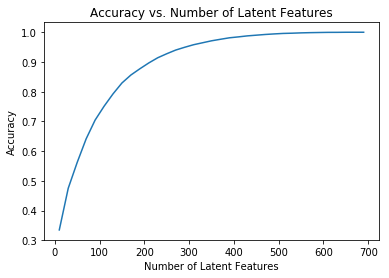

In [48]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [49]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    return user_item_train, user_item_test, test_idx, test_arts    

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [50]:
len([i for i in user_item_test.index if i in user_item_train.index])

20

In [51]:
len([i for i in user_item_test.index if i not in user_item_train.index])

662

In [52]:
len([i for i in user_item_test.columns if i in user_item_train.columns])

574

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [53]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [54]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [55]:
u_test = u_train[user_item_train.index.isin(test_idx),:]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
u_test.shape, vt_test.shape

((20, 714), (714, 574))

In [56]:
test_users = set(user_item_train.index) & set(user_item_test.index)
test_articles = set(user_item_train.columns) & set(user_item_test.columns)
user_item_test_only = user_item_test.loc[test_users, test_articles]

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_only, user_item_test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

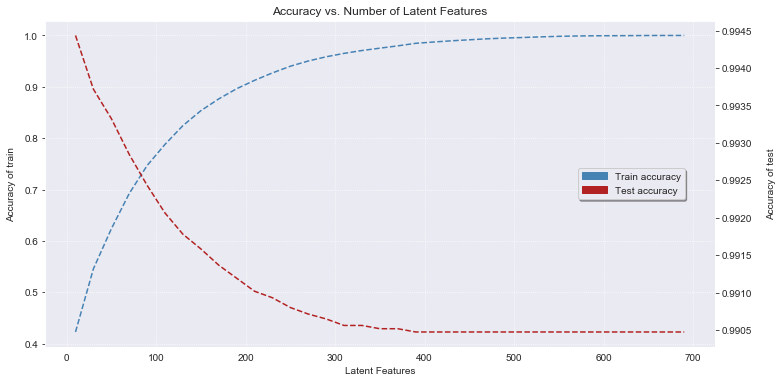

In [58]:
from matplotlib.patches import Rectangle

sns.set_style('dark')
fig, axs = plt.subplots(figsize = (12,6))
ax = axs.twinx()

axs.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color = '#4682B4', linestyle = '--');
ax.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color = '#B22222', linestyle = '--');

top_price = '#4682B4'
bottom_price = '#B22222' 

labels = ['Train accuracy', 'Test accuracy']
handles = [Rectangle((2,2),5,5,color=c) for c in [top_price, bottom_price]]
ax.set_ylabel('Accuracy of test', labelpad = 15);
axs.set_ylabel('Accuracy of train', labelpad = 8);
axs.set_xlabel('Latent Features');
axs.legend(handles, labels, loc = 'center right', frameon = True, shadow = True, 
           handlelength = 2.5, borderaxespad = 3, fontsize = 'medium');
axs.grid(linestyle=':')
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

After performing SVD and plotting the accuracy performance on both training and test sets, one can clearly see that as the training accuracy curve keeps improving based on the number of latent features, the test accuracy starts to drop. By examining the possible users in the test set that can be subject to recommendations based on SVM, there appear to be very few candidates, because of this, the model will likely perform very good on the train set and overfit. 

For a recommendation system for this dataset SVD would not be my ideal choice, and because of the results, the system would be a combination of different models: rank based, content based and maybe SVD, it will depend on the results it may show from an experiment design application. But i am confident that whatever the strategy of recommendation is, if implemented well by correctly assessing the metrics results of the experiment, i certainly think that it will be better for users to look for new articles to read using the recommendation system, than to not have any system and look manually for new articles.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 